#### Домашнее задание № 7

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

1. RFE - recursive feature elimination (есть в sklearn)
2. Boruta - shadow features
3. Target permutation 

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
df = pd.read_csv("./Heart Attack Data Set.csv")
df


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Файл Heart очень гиморойный и просто скачать его с сайта: https://archive.ics.uci.edu/ml/datasets.php хрен выйдет. Я нашел данные сделал файл вручную и немного заебся. Описание датасета привожу ниже.

Описание датасета:

Age: возраст пациента [лет]
Sex: пол пациента [1: мужской, 0: женский]

In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Сдесь мы видим что наш датасет содержит 13 столбцов включая 11 признаков

In [24]:
# числовые признаки
num_cols = df.select_dtypes(include=np.number).columns.tolist()
# категориальные признаки
cat_cols = df.select_dtypes(object).columns.tolist()
print(f'Числовых признаков {len(num_cols)}, а именно:\n{num_cols}\n'
      f'\nКатегориальных признаков {len(cat_cols)}, а именно:\n{cat_cols}')


Числовых признаков 14, а именно:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Категориальных признаков 0, а именно:
[]


In [25]:
df.isnull().sum()


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Пропусков нет

#### EDA

#### Категориальные признаки

In [27]:
print(f'{len(cat_cols)} категориальных признаков\n{cat_cols}\n')
# Extract details on categorical features
for i in cat_cols:
    unique_no = df[i].nunique()
    unique_name = df[i].unique().tolist()
    print(f'{i}, имеет {unique_no} уникальнх значения:\n{unique_name}\n')


0 категориальных признаков
[]



In [29]:
# Summary of categorical data
palette = ['#8abbd0', '#FB9851', '#36E2BD', '#D0E1E1']

for feature in cat_cols:
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    fig.patch.set_facecolor('#F2F2F2')

    sns.countplot(x=df[feature], data=df, ax=ax[0], palette=palette, alpha=0.8)
    for p, label in zip(ax[0].patches, df[feature].value_counts().index):
        ax[0].annotate(p.get_height(), (p.get_x() +
                       p.get_width()/3, p.get_height()*1.03))

    df[feature].value_counts().plot.pie(autopct='%1.1f%%', startangle=90,
                                        ax=ax[1], colors=palette, frame=True)
    ax[1].set_ylabel('')
    ax[1].set_title(feature)

    sns.histplot(x=feature, data=df, hue='HeartDisease',
                 ax=ax[2], alpha=0.3, shrink=.8)

plt.tight_layout
plt.show()


Числовые признаки

In [30]:
df.describe()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


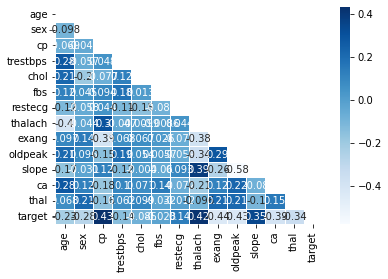

In [31]:
fig = plt.figure(figsize=(6, 4))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), cmap='Blues', annot=True, mask=mask, linewidth=0.5)
plt.show()


Корреляция между признаками невысокая

C:\Users\azhur\AppData\Local\Temp\ipykernel_24344\616302772.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=i,data=df, hue='HeartDisease',ax=ax[1],shade=True, alpha=0.3)


ValueError: Could not interpret value `HeartDisease` for parameter `hue`

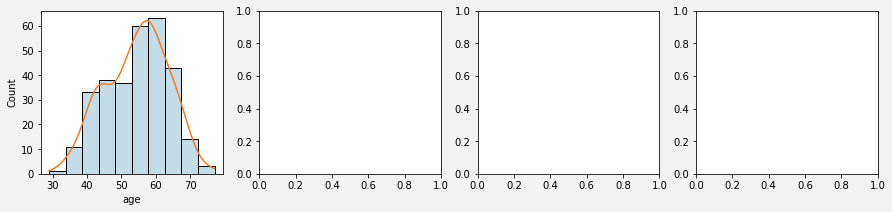

In [32]:
# Plots on numerical features to check data quality and data distribution
color = '#8abbd0'

for i in num_cols[:-1]:
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    fig.patch.set_facecolor('#F2F2F2')
    sns.histplot(df[i], bins=10, ax=ax[0],  color=color, kde=True)
    ax[0].lines[0].set_color('#F97A1F')
    sns.kdeplot(x=i, data=df, hue='HeartDisease',
                ax=ax[1], shade=True, alpha=0.3)
    sns.boxplot(x=i, data=df, ax=ax[2], color=color)
    sns.boxplot(x=i, data=df, hue='HeartDisease', y=[
                ""]*len(df), ax=ax[3], palette=['#8abbd0', '#F97A1F'], boxprops=dict(alpha=.3))
    plt.tight_layout
plt.show()


#### Feature engineering

Глядя на диаграмму выше, мы замечаем, что RestingBP имеет экстремальный выброс при 0. Вероятно, это неверное значение, мы удалим его из набора данных.

Cholesterol имеет несколько нулевых значений, мы заменим их медианой

Функции масштабирования:
В разделе EDA мы видим, что существует значительная разница в порядке величины между числовыми характеристиками. Поэтому будем использовать StandardScaler для настройки размеров объектов
Преобразование категориальных значений в числовые значения:
Будем использовать LabelEncoder для преобразования данных

Удалим выбросы по RestingBP

In [33]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline


In [35]:
row = df[df['RestingBP'] == 0].index
df = df.drop(df.index[row])


KeyError: 'RestingBP'

Используем LabelEncoder

In [36]:
le = LabelEncoder()
#heart[cat_cols] = heart[cat_cols].astype('str').apply(le.fit_transform)
df[cat_cols] = df[cat_cols].apply(le.fit_transform)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [38]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        self.median_values=X['Cholesterol'].median()
        return self

    def transform(self, X):
        if self.key=='Cholesterol':
            row = X[X['Cholesterol']==0].index
            X.loc[row, 'Cholesterol'] = self.median_values
            
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [39]:
continuos_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
base_cols=[*cat_cols+['FastingBS']]

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
'''for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))'''
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [40]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [41]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

KeyError: 'Cholesterol'

In [42]:
cls=Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42))
])

In [43]:
cls.fit(X_train, y_train)

KeyError: 'Cholesterol'

In [44]:
y_predict = cls.predict(X_test)

KeyError: "None of [Index(['Age'], dtype='object')] are in the [columns]"

In [45]:
results = {
    'approach': [],
    'f1': [],
    'roc': [],
    'recall':[],
    'precision':[]
}

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 



results['approach'].append('rfc')
results['f1'].append(f1_score(y_test, y_predict))
results['roc'].append(roc_auc_score(y_test, y_predict))
results['recall'].append(recall_score(y_test, y_predict, average='binary'))
results['precision'].append(precision_score(y_test, y_predict, average='binary'))

evaluate_results(y_test, y_predict)

NameError: name 'y_predict' is not defined

In [46]:
cls[1].feature_importances_

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [47]:
features = pd.DataFrame(cls[1].feature_importances_, 
                        X_train.columns, 
                        columns=['coefficient']).sort_values(by=['coefficient'], ascending=False)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [48]:
features

NameError: name 'features' is not defined

In [49]:
import shap

# load JS visualization code to notebook
shap.initjs()

ModuleNotFoundError: No module named 'shap'

In [ ]:
explainer = shap.TreeExplainer(cls[1])
shap_values = explainer.shap_values(X_train)

In [ ]:
shap_values1=shap_values[0]

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values1, X_train)

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0][25],  X_train.iloc[25,:])